In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Util import mask_util, util
from lenstronomy.Workflow.fitting_sequence import FittingSequence

%matplotlib inline

/home/akbro_10/.local/lib/python3.8/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


In [2]:
with h5py.File("DESIJ0136-0008_F140W.h5", "r") as f:
    kwargs_data = {}

    for key in f:
        if key == "exposure_time":
            kwargs_data[key] = f[key][()]
            continue
        kwargs_data[key] = f[key][()]

# print kwargs_data
for key in kwargs_data:
    print(f"{key}: {kwargs_data[key]}")

background_rms: 0.020226480636773847
dec_at_xy_0: -10.03999999999999
exposure_time: [[480.17502 478.00955 545.1479  ... 453.76492 495.06876 351.65335]
 [539.82275 396.43954 378.49487 ... 577.67755 321.1616  305.41653]
 [347.75266 582.9625  483.96677 ... 425.66187 318.69778 337.77414]
 ...
 [431.28677 453.53516 507.60822 ... 417.27905 406.37323 441.34796]
 [373.92175 272.3933  383.2737  ... 431.20264 502.59534 595.19434]
 [392.85666 451.82388 520.1835  ... 609.24677 391.4596  412.2425 ]]
image_data: [[-0.01320017  0.00887198  0.01452675 ... -0.00496921 -0.00073036
   0.01501495]
 [-0.008774    0.02328778  0.00136724 ... -0.04160036  0.0106275
   0.00662912]
 [-0.03182266 -0.00972193  0.00459631 ... -0.01573473  0.0048767
   0.00191049]
 ...
 [ 0.00095618  0.01111637  0.00379965 ...  0.01628057  0.00888098
  -0.01454695]
 [ 0.00781532 -0.00317025  0.01218377 ...  0.00941897 -0.00657219
  -0.0251791 ]
 [ 0.00606052  0.00711807  0.01721074 ...  0.05797264 -0.00717967
  -0.02253795]]
ra_at_

In [3]:
with h5py.File("psf_F140W.h5", "r") as f:
    kwargs_psf = {}
    for key in f:
        kwargs_psf[key] = f[key][()]
kwargs_psf["psf_type"] = "PIXEL"
print(kwargs_psf)

{'kernel_point_source': array([[5.7422681e-06, 4.5087054e-06, 2.4900439e-06, ..., 1.8486933e-06,
        3.2385867e-06, 4.4331632e-06],
       [3.9503216e-06, 9.9817180e-06, 6.5966469e-06, ..., 3.9997908e-06,
        6.6143798e-06, 4.1430776e-06],
       [2.9697005e-06, 5.5563592e-06, 1.2795975e-05, ..., 7.8115263e-06,
        5.1404800e-06, 1.7530243e-06],
       ...,
       [1.6921831e-06, 3.7347368e-06, 7.6415899e-06, ..., 1.1465157e-05,
        5.3933368e-06, 1.6360833e-06],
       [2.8819463e-06, 6.2348781e-06, 4.7564718e-06, ..., 4.5906190e-06,
        8.7221979e-06, 3.7005334e-06],
       [3.7170516e-06, 3.6243027e-06, 1.6518559e-06, ..., 2.0127884e-06,
        3.2246478e-06, 5.1252514e-06]], dtype=float32), 'psf_type': 'PIXEL'}


/tmp/ipykernel_5041/4184533954.py:2: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(image_data), origin="lower", cmap="cubehelix")


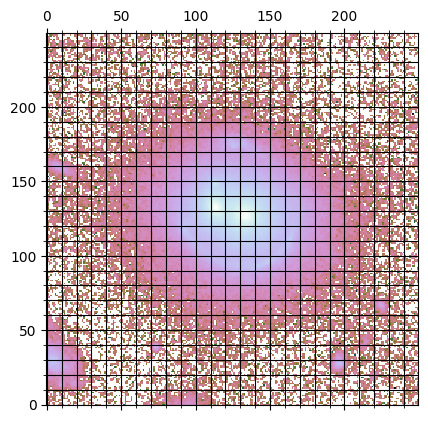

In [4]:
image_data = kwargs_data["image_data"]
plt.matshow(np.log10(image_data), origin="lower", cmap="cubehelix")
plt.grid(which="both", color="black")
plt.minorticks_on()
plt.grid(which="minor", color="black")


# plt.matshow(np.log10(image_data), origin='lower', cmap='cubehelix');

/tmp/ipykernel_5041/2256829137.py:54: RuntimeWarning: invalid value encountered in log10
  axes[0].imshow(np.log10(image_data), origin="lower", cmap="cubehelix")
/tmp/ipykernel_5041/2256829137.py:66: RuntimeWarning: divide by zero encountered in log10
  image_after_mask = np.log10(image_data * mask)
/tmp/ipykernel_5041/2256829137.py:66: RuntimeWarning: invalid value encountered in log10
  image_after_mask = np.log10(image_data * mask)


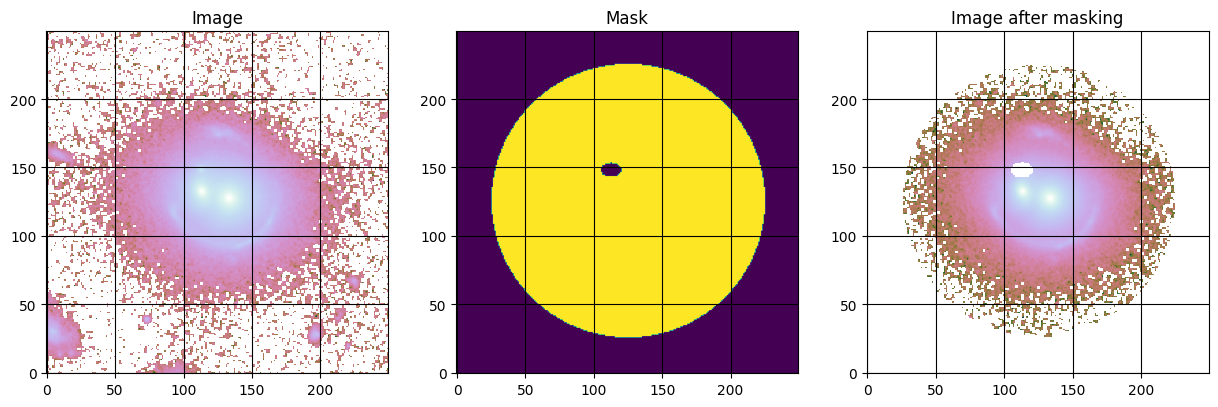

In [5]:
ra_at_xy_0 = kwargs_data["ra_at_xy_0"]
dec_at_xy_0 = kwargs_data["dec_at_xy_0"]
transform_pix2angle = kwargs_data["transform_pix2angle"]

coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
num_pix = len(kwargs_data["image_data"])

x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)

r = 8  # arcseconds
lens_center_ra = 0
lens_center_dec = 0

mask_outer = mask_util.mask_center_2d(
    lens_center_ra,
    lens_center_dec,
    r,
    util.image2array(x_coords),
    util.image2array(y_coords),
)


# for the galaxy at the center
# mask_ext_center = mask_util.mask_ellipse(
#     util.image2array(x_coords),
#     util.image2array(y_coords),
#     lens_center_ra + 0.9,  # 1.0
#     lens_center_dec + 0.5,
#     0.9,  # 0.8
#     1.2,  # 0.8
#     0,
# )

# for the galaxy at 11 o clock
mask_ext_eleven = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 1.0,
    lens_center_dec + 1.8,
    0.6,
    0.4,
    0,
)
#* (1 - mask_ext_center)
mask = (1 - mask_outer) * (1 - mask_ext_eleven)
mask[mask >= 1] = 1
mask[mask < 0] = 0
mask = mask.reshape(num_pix, num_pix)


# Setting the subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 15))

axes[0].imshow(np.log10(image_data), origin="lower", cmap="cubehelix")
axes[0].grid(True, color="black")
# axes[0].minorticks_on()
# axes[0].grid(which='minor', color='black')
axes[0].set_title("Image")


axes[1].imshow(mask, origin="lower")
axes[1].grid(True, color="black")
axes[1].set_title("Mask")


image_after_mask = np.log10(image_data * mask)

axes[2].imshow(image_after_mask, origin="lower", cmap="cubehelix")
axes[2].grid(True, color="black")
axes[2].set_title("Image after masking")


# Show the plots
plt.show()

In [6]:
lens_model_list = ["EPL", "SHEAR", "SIE"]  # gamma1, gamma2, ra_0, dec_0
source_model_list = ["SERSIC_ELLIPSE", "SHAPELETS"]  # beta, n_max, center_x, center_y
lens_light_model_list = ["SERSIC_ELLIPSE", "SERSIC_ELLIPSE", "SERSIC_ELLIPSE"]

In [7]:
# lens galaxy's mass model

fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({})

kwargs_lens_init.append(
    {
        "theta_E": 1.22,
        "gamma": 1.8,
        "e1": 0.0,
        "e2": 0.0,
        "center_x": 0.0,
        "center_y": 0.0,
    }
)

kwargs_lens_sigma.append(
    {
        "theta_E": 0.2,
        "gamma": 0.1,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.5,
        "center_y": 0.5,
    }
)

kwargs_lower_lens.append(
    {
        "theta_E": 0.01,
        "gamma": 1.5,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": -10,
        "center_y": -10,
    }
)

kwargs_upper_lens.append(
    {
        "theta_E": 10.0,
        "gamma": 3.0,
        "e1": 0.5,
        "e2": 0.5,
        "center_x": 10,
        "center_y": 10,
    }
)


fixed_lens.append({"ra_0": 0.0, "dec_0": 0.0})  # Shear

kwargs_lens_init.append({"gamma1": 0.0,
                         "gamma2": 0.0,})

kwargs_lens_sigma.append({"gamma1": 0.05, 
                          "gamma2": 0.05})  # Changed

kwargs_lower_lens.append({"gamma1": -0.4, 
                          "gamma2": -0.4})

kwargs_upper_lens.append({"gamma1": 0.4, 
                          "gamma2": 0.4})

lens_params = [
    kwargs_lens_init,
    kwargs_lens_sigma,
    fixed_lens,
    kwargs_lower_lens,
    kwargs_upper_lens,
]

#SIE parameter

satellite_center_x = +0.9
satellite_center_y = +0.5
satellite_centroid_bound = 0.4  #0.4

fixed_lens.append({})
kwargs_lens_init.append(
    {
        "theta_E": 0.4,  #0.4
        "e1": 0.3, #0.38
        "e2": 0.1, #0.16
        "center_x": satellite_center_x,
        "center_y": satellite_center_y,
    }
)
kwargs_lens_sigma.append(
    {
        "theta_E": 0.1,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": satellite_center_x / 4,
        "center_y": satellite_center_y / 4,
    }
)
kwargs_lower_lens.append(
    {
        "theta_E": 0.0001,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": satellite_center_x - satellite_centroid_bound,
        "center_y": satellite_center_y - satellite_centroid_bound,
    }
)
kwargs_upper_lens.append(
    {
        "theta_E": 2.0,  #2.0
        "e1": 0.5,
        "e2": 0.5,
        "center_x": satellite_center_x + satellite_centroid_bound,
        "center_y": satellite_center_y + satellite_centroid_bound,
    }
)

In [8]:
# source galaxy's light model
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

fixed_source.append({"n_sersic": 1.0})

kwargs_source_init.append(
    {
        "R_sersic": 0.38,
        "n_sersic": 1.0,
        "e1": 0.0,
        "e2": 0.0,
        "center_x": 0.0,
        "center_y": 0.0,
        "amp": 16,
    }
)

kwargs_source_sigma.append(
    {
        "R_sersic": 0.1,
        "n_sersic": 0.5,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.2,
        "center_y": 0.2,
        "amp": 10,
    }
)

kwargs_lower_source.append(
    {
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)

kwargs_upper_source.append(
    {
        "R_sersic": 10,
        "n_sersic": 5.0,
        "e1": 0.5,
        "e2": 0.5,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)



fixed_source.append({"n_max": 10})  # Shapelets, 4 previously 

kwargs_source_init.append({"beta": 0.05,
                           "center_x": 0.0,
                           "center_y": 0.0,})


kwargs_source_sigma.append({"beta": 0.5, 
                            "center_x": 0.2, 
                            "center_y": 0.2})

kwargs_lower_source.append({"beta": 0.01, 
                            "center_x": -10.0, 
                            "center_y": -10.0})

kwargs_upper_source.append({"beta": 50, 
                            "center_x": 10.0, 
                            "center_y": 10.0
                           })

source_params = [
    kwargs_source_init,
    kwargs_source_sigma,
    fixed_source,
    kwargs_lower_source,
    kwargs_upper_source,
]

joint_shapelets_with_sersic = [[0, 1, ["center_x", "center_y"]]]

In [9]:
# lens galaxy's light model
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

fixed_lens_light.append({"n_sersic": 4.0}) #follow Rafee bhaiya's if this doesn't work

kwargs_lens_light_init.append(
    {
        "R_sersic": 0.5,
        "n_sersic": 4.0,
        "e1": 0.0,
        "e2": 0.0,
        "center_x": 0.0,
        "center_y": 0.0,
        "amp": 16,
    }
)

kwargs_lens_light_sigma.append(
    {
        "R_sersic": 0.3,
        "n_sersic": 1,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 10,
    }
)

kwargs_lower_lens_light.append(
    {
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)

kwargs_upper_lens_light.append(
    {
        "R_sersic": 10,
        "n_sersic": 5.0,
        "e1": 0.5,
        "e2": 0.5,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)


#2nd sersic ellipse params

fixed_lens_light.append({"n_sersic": 4.0})

kwargs_lens_light_init.append(
    {
        "R_sersic": 0.5,
        "n_sersic": 4.0,
        "e1": 0.0,
        "e2": 0.0,
        "center_x": 0.0,
        "center_y": 0.0,
        "amp": 16,
    }
)
kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 1,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)



#3rd Sersic 

fixed_lens_light.append({"n_sersic": 4.0})

kwargs_lens_light_init.append(
    {
        "R_sersic": 0.4,
        "n_sersic": 2,
        "e1": 0.0339,
        "e2": -0.0926,
        "center_x": satellite_center_x,
        "center_y": satellite_center_y,
        "amp": 1,
    }
)
kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": satellite_centroid_bound / 4,
        "center_y": satellite_centroid_bound / 4,
        "amp": 1,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": satellite_center_x - satellite_centroid_bound,
        "center_y": satellite_center_y - satellite_centroid_bound,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": satellite_center_x + satellite_centroid_bound,
        "center_y": satellite_center_y + satellite_centroid_bound,
        "amp": 100,
    }
)


joint_lens_with_light = [[2, 
                               2, 
                               ["center_x", "center_y", "e1", "e2"]]]

joint_lens_light_with_lens_light = [[0, 
                                     1, 
                                     ["center_x", "center_y", "e1", "e2"]]]

lens_light_params = [
    kwargs_lens_light_init,
    kwargs_lens_light_sigma,
    fixed_lens_light,
    kwargs_lower_lens_light,
    kwargs_upper_lens_light,
]

In [10]:
kwargs_params = {
    "lens_model": lens_params,
    "source_model": source_params,
    "lens_light_model": lens_light_params,
}

kwargs_constraints = {
    "joint_lens_light_with_lens_light": joint_lens_light_with_lens_light,
    "joint_source_with_source": joint_shapelets_with_sersic,
    "joint_lens_with_light": joint_lens_with_light,
}

In [11]:
kwargs_likelihood = {"check_bounds": True, "image_likelihood_mask_list": [mask]}

kwargs_numerics = {"supersampling_factor": 1, "supersampling_convolution": False}

In [12]:
kwargs_model = {
    "lens_model_list": lens_model_list,
    "source_light_model_list": source_model_list,
    "lens_light_model_list": lens_light_model_list,
}

multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]

kwargs_data_joint = {
    "multi_band_list": multi_band_list,
    "multi_band_type": "single-band",
}

In [13]:
fitting_seq = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
)

fitting_kwargs_list = [
    #['update_settings', {'lens_add_fixed': [[0, ['gamma']]]}],
    [
        "PSO",
        {"sigma_scale": 1.0, "n_particles": 100, "n_iterations": 100},
    ]
]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-1.334612438188645 reduced X^2 of best position
-20831.96554768656 log likelihood
31218 effective number of data points
[{'theta_E': 0.2795142116115129, 'gamma': 2.1872711532571056, 'e1': -0.3723489017665339, 'e2': 0.1564405463949475, 'center_x': -0.08028717937223306, 'center_y': 8.348549471636735}, {'gamma1': -0.03341693359935769, 'gamma2': 0.043978757869896336, 'ra_0': 0.0, 'dec_0': 0.0}, {'theta_E': 0.7072997754439575, 'e1': -0.11585599463013185, 'e2': 0.07929944245877595, 'center_x': 0.9540270267786881, 'center_y': 0.5539225419345388}] lens result
[{'amp': 1, 'R_sersic': 0.7942325456452631, 'n_sersic': 1.0, 'e1': -0.3007565995360994, 'e2': -0.35665811105041595, 'center_x': -0.20504196029092742, 'center_y': 0.462452678565684}, {'amp': 1, 'n_max': 10, 'beta': 1.0099143555685965, 'center_x': -0.20504196029092742, 'center_y': 0.462452678565684}] source result
[{'amp': 1, 'R_sersic': 0.1475374629927011

-1.3305208862924822 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.3305208862925044


/home/akbro_10/.local/lib/python3.8/site-packages/lenstronomy/Plots/model_band_plot.py:43: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/home/akbro_10/.local/lib/python3.8/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/home/akbro_10/.local/lib/python3.8/site-packages/lenstronomy/Plots/model_band_plot.py:136: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._model), origin='lower', vmin=v_min, vmax=v_max,
/tmp/ipykernel_5041/911841336.py:26: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


TypeError: subplots_adjust() got an unexpected keyword argument 'unconvolved'

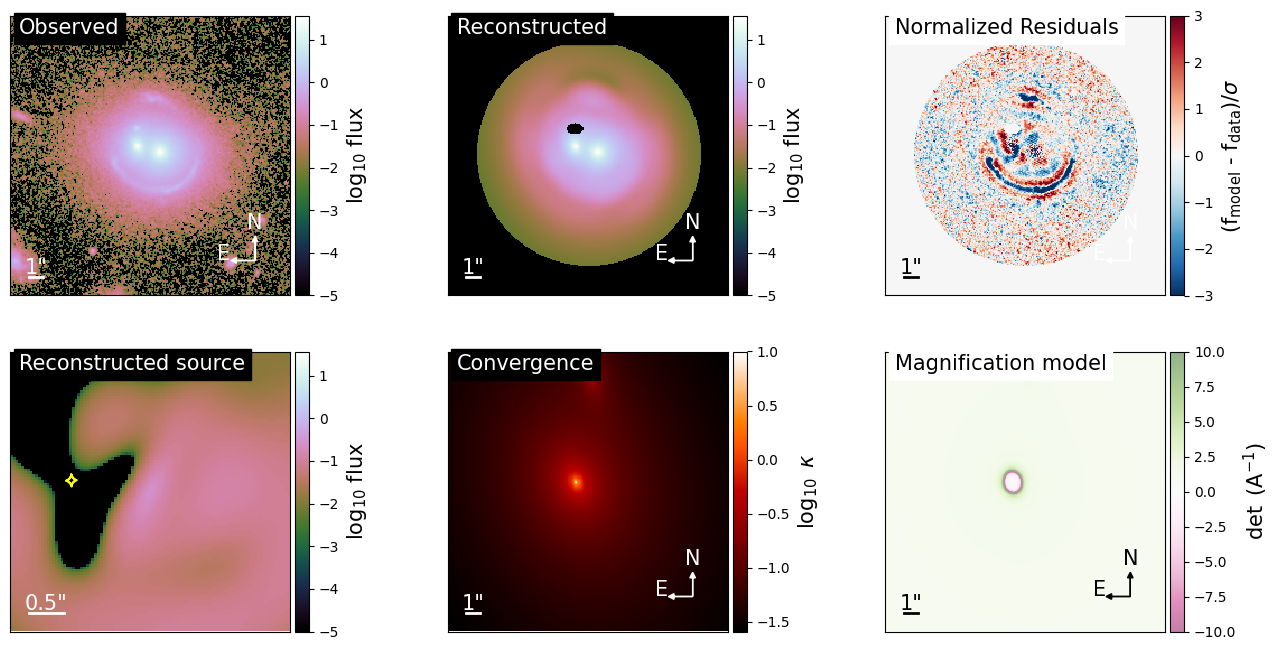

In [15]:
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3, cmap="RdBu_r")

model_plot.source_plot(ax=axes[1, 0], 
                       deltaPix_source=0.04, 
                       numPix=100, 
                       with_caustics=True, 
                       scale_size=0.5)

model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")

model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")

f.tight_layout()
f.subplots_adjust(
    left=None,
    bottom=None,
    unconvolved=True,
    right=None,
    top=None,
    wspace=0.0,
    hspace=0.05,
)
plt.show()

/home/akbro_10/.local/lib/python3.8/site-packages/lenstronomy/Plots/model_band_plot.py:511: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(model), origin='lower', vmin=v_min, vmax=v_max,


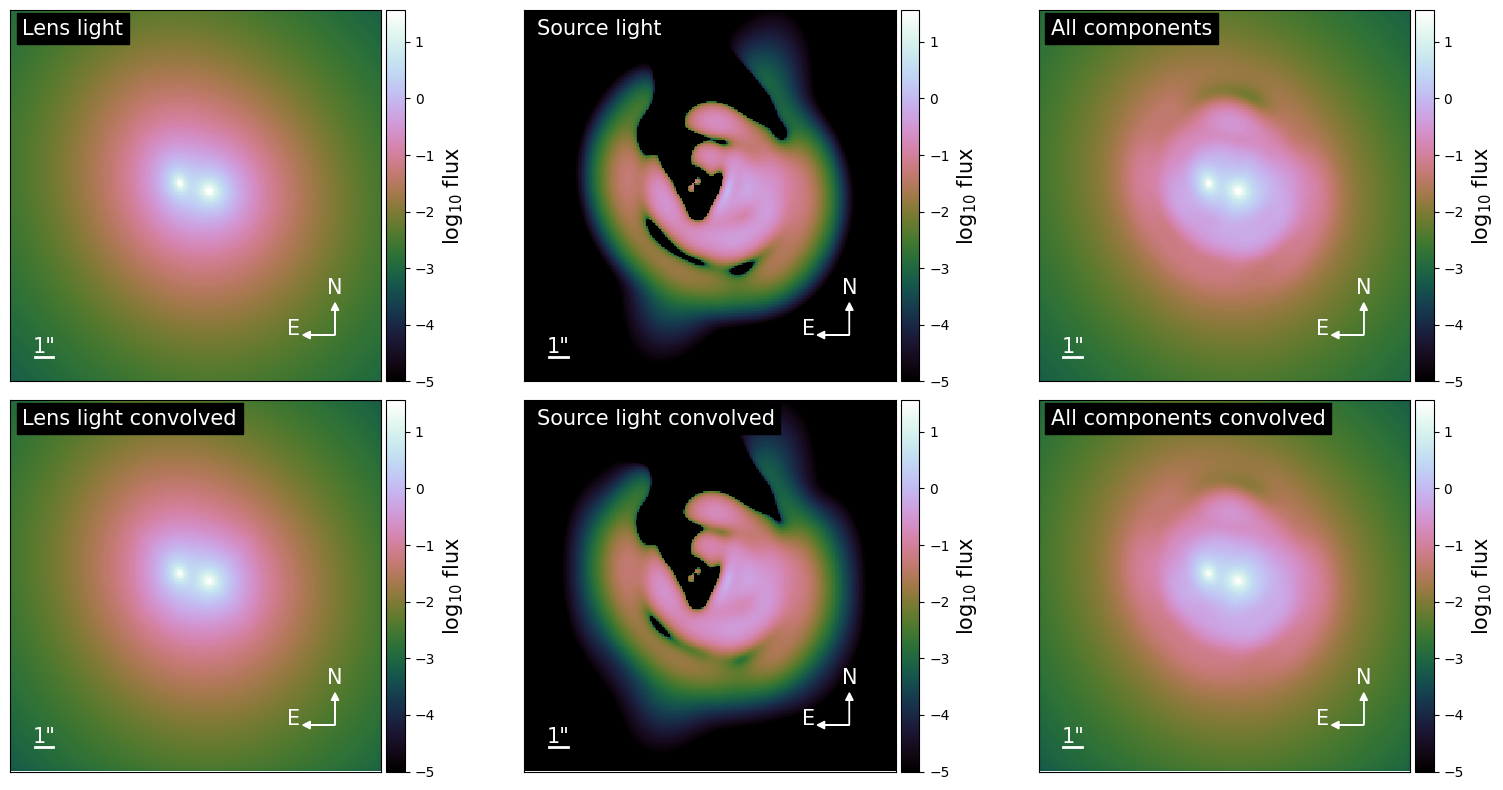

{'kwargs_lens': [{'theta_E': 0.2795142116115129, 'gamma': 2.1872711532571056, 'e1': -0.3723489017665339, 'e2': 0.1564405463949475, 'center_x': -0.08028717937223306, 'center_y': 8.348549471636735}, {'gamma1': -0.03341693359935769, 'gamma2': 0.043978757869896336, 'ra_0': 0.0, 'dec_0': 0.0}, {'theta_E': 0.7072997754439575, 'e1': -0.11585599463013185, 'e2': 0.07929944245877595, 'center_x': 0.9540270267786881, 'center_y': 0.5539225419345388}], 'kwargs_source': [{'amp': 46.77435825368583, 'R_sersic': 0.7942325456452631, 'n_sersic': 1.0, 'e1': -0.3007565995360994, 'e2': -0.35665811105041595, 'center_x': -0.20504196029092742, 'center_y': 0.462452678565684}, {'amp': array([-2.43152363e+00, -7.12136241e+01, -3.59270380e+01,  9.50627936e+01,
        2.88650980e+01,  4.73561823e+01, -1.26222205e+01, -2.75118296e+01,
       -5.95034302e-01, -2.99936249e+01,  2.86631514e+01, -2.02865675e+01,
       -1.16357414e+01,  1.00009138e+01,  3.35549886e+01, -6.39325776e+00,
       -2.15511945e+01, -1.6121474

In [16]:
f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)

model_plot.decomposition_plot(
    ax=axes[1, 0],
    text="Lens light convolved",
    lens_light_add=True,
)

model_plot.decomposition_plot(
    ax=axes[0, 1],
    text="Source light",
    source_add=True,
    unconvolved=True,
)

model_plot.decomposition_plot(
    ax=axes[1, 1],
    text="Source light convolved",
    source_add=True,
)

model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)

model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)

f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()
print(kwargs_result)